# **Loading data and packages**

In [28]:
!pip install scikit-learn==1.2.2

**Libraries import**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTENC, ADASYN
from imblearn.metrics import geometric_mean_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

**Data import**

In [2]:
# Defining global variables to store the DataFrame
df = pd.DataFrame()
dataset_name = None
X = None
y = None
balancing_method_selected = None

# Function to list CSV files in the directory
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

# Function to load and process the selected dataset
def load_and_process_data(selected_file):
    global df, dataset_name, X, y
    dataset_name = selected_file
    file_path = os.path.join('..', 'datasets', 'feature_selection', dataset_name)

    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None

    df = pd.read_csv(file_path)

    # Converting 'Gender' to numeric values
    if 'Gênero' in df.columns:
        df['Gênero'] = df['Gênero'].replace({'M': 0, 'F': 1})

    # Normalizing 'Age_clinic'
    if 'Idade_clinica' in df.columns:
        scaler = MinMaxScaler()
        df['Idade_clinica'] = scaler.fit_transform(df[['Idade_clinica']])

    # Defining X (features) and y (target)
    X = df.drop(columns=['PROVAVEL_HAM/TSP']) 
    y = df['PROVAVEL_HAM/TSP'] 

    print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    return df.head()

# Function to define the selected balancing method
def set_balancing_method(method):
    global balancing_method_selected  
    balancing_method_selected = method  
    print(f"Método de balanceamento selecionado: {balancing_method_selected}")

# Function to apply the selected balancing method
def apply_balancing(X, y):
    global balancing_method_selected
    if balancing_method_selected is None:
        print("Nenhum método de balanceamento foi selecionado.")
        return X, y

    if balancing_method_selected == 'Random Over Sampler':
        balancer = RandomOverSampler()
    elif balancing_method_selected == 'SMOTENC':
        # Identify categorical columns
        categorical_features = [i for i, col in enumerate(X.columns) if col != 'Idade_clinica']
        balancer = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        balancer = RandomUnderSampler()
    elif balancing_method_selected == 'Tomek Links':
        balancer = TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return X, y

    # Applying the balancing method
    X_res, y_res = balancer.fit_resample(X, y)
    return X_res, y_res

# Define the directory where the CSV files are located
directory = '../datasets/feature_selection/'

# List the CSV files available in the directory
csv_files = list_csv_files(directory)

# Create a selection widget with the files listed
file_selector = widgets.Dropdown(
    options=csv_files,
    description='Select File:'
)

# Create a widget to select the balancing method
balancing_methods = ['Random Over Sampler', 'SMOTENC', 'Random Under Sampler', 'Tomek Links']
method_selector = widgets.Dropdown(
    options=balancing_methods,
    description='Balancing Method:'
)

# Interactive function to load and process the selected CSV file
@interact(selected_file=file_selector)
def load_and_process_selected_file(selected_file):
    return load_and_process_data(selected_file)

# Interactive function to apply the selected balancing method
@interact(selected_method=method_selector)
def apply_selected_balancing_method(selected_method):
    set_balancing_method(selected_method)
    X_res, y_res = apply_balancing(X, y)  # Aplica o balanceamento aos dados carregados
    print(f"Shape dos dados balanceados: {X_res.shape}, {y_res.shape}")


interactive(children=(Dropdown(description='Select File:', options=('df_Clinic_dataset_cat_2_ROS.csv', 'df_Cli…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [3]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '../models/'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AB carregado com sucesso.
Modelo LSVM carregado com sucesso.


In [4]:
print(balancing_method_selected)

Random Under Sampler


# **Model evaluation**

Generation of the results

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# Lista para armazenar os resultados
results = []

# Definir a estratégia Leave-One-Out
loo = LeaveOneOut()

# Função para aplicar o método de balanceamento selecionado
def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        return SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print("Nenhum método de balanceamento válido selecionado.")
        return None

# Iterando sobre os classificadores
for clf_name, clf in classifiers.items():
    balancing_method = get_balancing_method()
    if balancing_method is None:
        print(f"Erro: Nenhum método de balanceamento válido para o classificador {clf_name}. Pulando este classificador.")
        continue

    # Definir o pipeline
    pipeline = Pipeline([
        ('balancing', balancing_method),
        ('classifier', clf)
    ])

    # Armazenar métricas por iteração
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    gmean_scores = []

    # Executar Leave-One-Out manualmente
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinar e prever
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        try:
            y_prob = pipeline.predict_proba(X_test)[:, 1]
        except AttributeError:
            if hasattr(clf, "decision_function"):
                y_prob = pipeline.decision_function(X_test)
                # Normalizar
                y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
            else:
                y_prob = np.zeros_like(y_pred)

        # Adicionar métricas da iteração
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        roc_auc_scores.append(roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan)
        gmean_scores.append(geometric_mean_score(y_test, y_pred))

    # Calcular métricas globais
    y_pred_global = cross_val_predict(pipeline, X, y, cv=loo)
    try:
        y_prob_global = cross_val_predict(pipeline, X, y, cv=loo, method='predict_proba')[:, 1]
    except AttributeError:
        if hasattr(clf, "decision_function"):
            y_prob_global = cross_val_predict(pipeline, X, y, cv=loo, method='decision_function')
            y_prob_global = (y_prob_global - y_prob_global.min()) / (y_prob_global.max() - y_prob_global.min())
        else:
            y_prob_global = np.zeros_like(y_pred_global)

    # Adicionar métricas ao DataFrame
    results.append({
        'classifier': clf_name,
        'Accuracy': accuracy_score(y, y_pred_global),
        'Accuracy Std': np.std(accuracy_scores),
        'Precision': precision_score(y, y_pred_global, zero_division=0),
        'Precision Std': np.std(precision_scores),
        'Recall': recall_score(y, y_pred_global, zero_division=0),
        'Recall Std': np.std(recall_scores),
        'F1': f1_score(y, y_pred_global, zero_division=0),
        'F1 Std': np.std(f1_scores),
        'G-Mean': geometric_mean_score(y, y_pred_global),
        'G-Mean Std': np.std(gmean_scores),    
        'ROC AUC': roc_auc_score(y, y_prob_global),
    })

# Converter resultados para DataFrame
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)


/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bioinfo-icb/anaconda3/envs/ML_H

  classifier  Accuracy  Accuracy Std  Precision  Precision Std    Recall  \
0         DT  0.765306      0.423807   0.523810       0.315668  0.458333   
1         GB  0.693878      0.460881   0.431818       0.395334  0.791667   
2         LR  0.653061      0.475996   0.368421       0.349927  0.583333   
3        MLP  0.744898      0.435919   0.333333       0.100499  0.041667   
4         NB  0.653061      0.475996   0.291667       0.257539  0.291667   
5         RF  0.602041      0.489477   0.325581       0.349927  0.583333   
6        SVM  0.785714      0.410326   0.666667       0.239742  0.250000   
7        KNN  0.744898      0.435919   0.466667       0.257539  0.291667   
8         AB  0.714286      0.451754   0.447368       0.378653  0.708333   
9       LSVM  0.673469      0.468944   0.413043       0.395334  0.791667   

   Recall Std        F1    F1 Std    G-Mean  G-Mean Std   ROC AUC  
0    0.315668  0.488889  0.315668  0.629600    0.423807  0.408784  
1    0.395334  0.558824  0.

/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home

In [8]:
print(df.columns)

Index(['Gênero', 'Idade_clinica', 'Comprometimento da função urinária',
       'Dor MMII', 'Parestesia MMII', 'Paresia/Fraqueza MMII',
       'Neuropatia MMSS', 'Função Motora', 'Expression_CD39_Diplotypes',
       'PROVAVEL_HAM/TSP'],
      dtype='object')


In [6]:
output_directory = '../results'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Caminho do arquivo
output_file = os.path.join(output_directory, 'results_metrics.csv')

# Salvar o DataFrame em formato CSV
results_df.to_csv(output_file, index=False)

# Exibir mensagem de confirmação
print(f"Resultados salvos em: {output_file}")


Resultados salvos em: ../results/results_metrics.csv


Heatmap plot

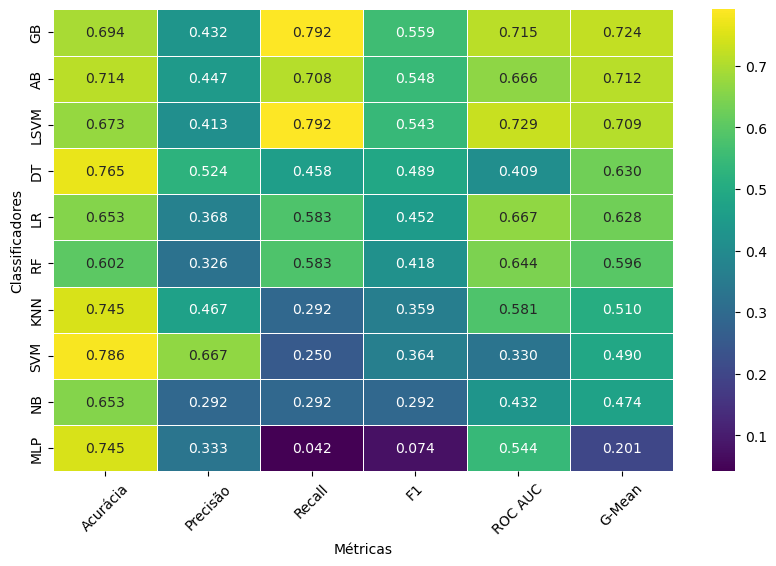

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Defining the names of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Translation dictionary for metric names
translation_dict = {
    'Accuracy': 'Acurácia',
    'Precision': 'Precisão',
    'Recall': 'Recall',
    'F1': 'F1',
    'ROC AUC': 'ROC AUC',
    'G-Mean': 'G-Mean'
}

# Selecting the metrics for the heatmap and configuring the index
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Renaming the columns to Portuguese
heatmap_df.rename(columns=translation_dict, inplace=True)

# Sorting the DataFrame by G-Mean value
heatmap_df = heatmap_df.sort_values(by=translation_dict['G-Mean'], ascending=False)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
#plt.title('Mapa de calor das métricas avaliadas')
plt.xlabel('Métricas')
plt.ylabel('Classificadores')
plt.xticks(rotation=45)
plt.savefig('../results/heatmap.jpeg')
plt.show()


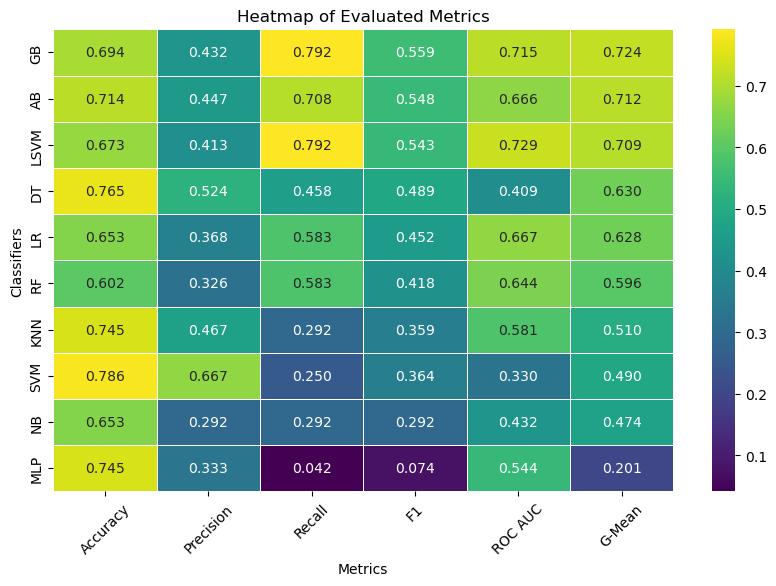

In [12]:
# Defining the names of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Selecting the metrics for the heatmap and configuring the index
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Sorting the DataFrame by G-Mean value
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Heatmap of Evaluated Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('../results/heatmap.jpeg')
plt.show()


Polar plot

Dropdown(description='Modelo 1', options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN'), va…

Dropdown(description='Modelo 2', index=1, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 3', index=2, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 4', index=3, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Button(description='Gerar Gráfico', style=ButtonStyle())

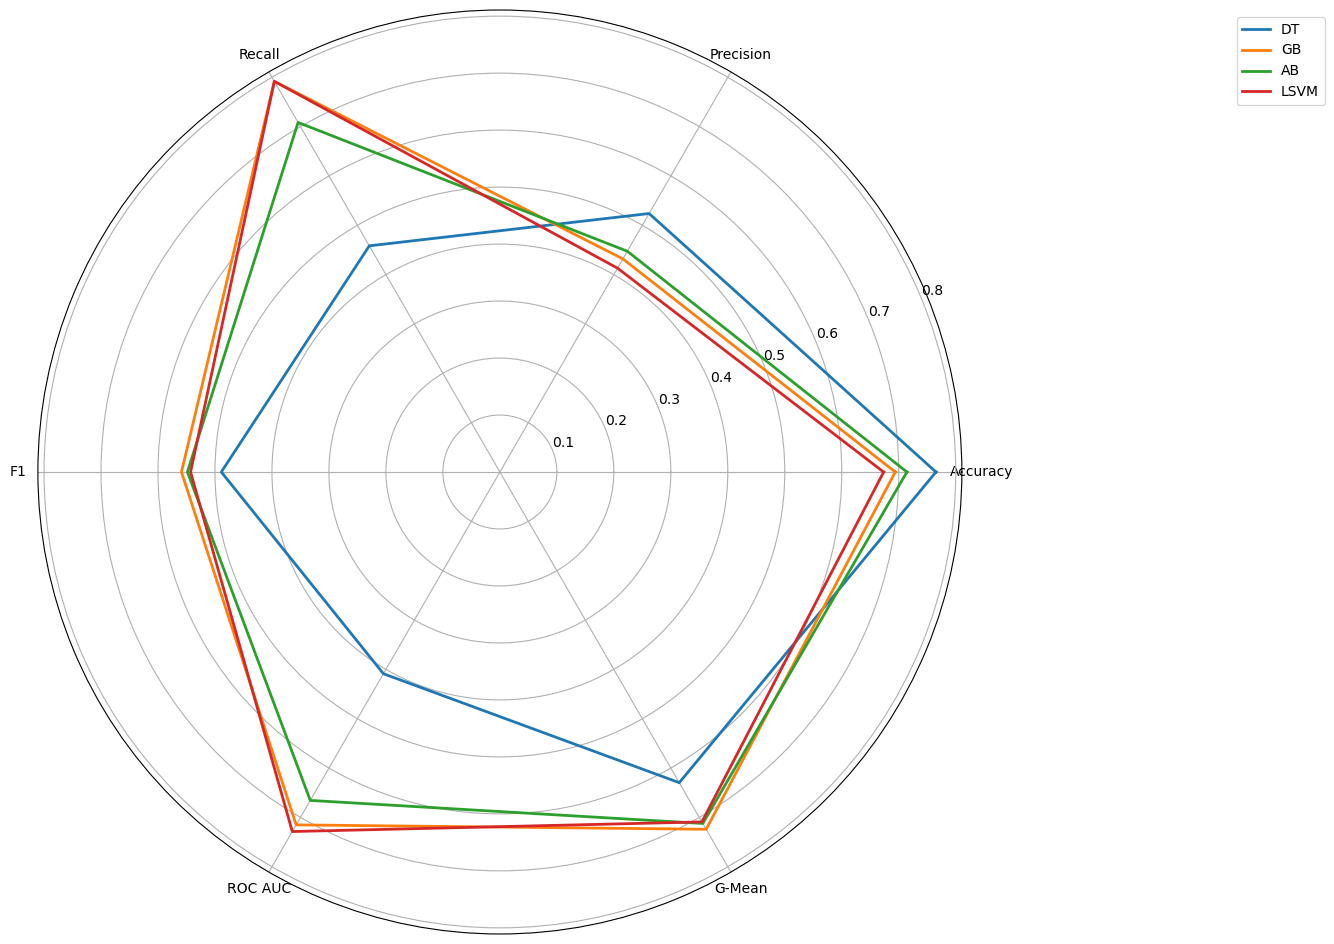

Gráfico salvo em: ../results/polar_plot.jpeg


In [9]:
# Define the available classifiers
available_models = ['GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN']

# Model selection widgets
model_selector_1 = widgets.Dropdown(options=available_models, description='Modelo 1', value=available_models[0])
model_selector_2 = widgets.Dropdown(options=available_models, description='Modelo 2', value=available_models[1])
model_selector_3 = widgets.Dropdown(options=available_models, description='Modelo 3', value=available_models[2])
model_selector_4 = widgets.Dropdown(options=available_models, description='Modelo 4', value=available_models[3])

# Display the widgets to the user
display(model_selector_1, model_selector_2, model_selector_3, model_selector_4)
def plot_selected_models(results_df):
    # Get the selected models from the dropdowns
    selected_models = [model_selector_1.value, model_selector_2.value, model_selector_3.value, model_selector_4.value]

    # Check for duplicates in the selected templates
    if len(selected_models) != len(set(selected_models)):
        print("Por favor, selecione modelos diferentes em cada widget.")
        return

    # Filter the results for the selected models
    results_df_filtered = results_df[results_df['classifier'].isin(selected_models)]

    # Creating the figure for the polar graph
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

    # Iterate over each row of the filtered DataFrame and plot the metrics on the polar graph
    for i, row in results_df_filtered.iterrows():
        # Take the metrics in order
        metrics = [row['Accuracy'], row['Precision'], row['Recall'], row['F1'], row['ROC AUC'], row['G-Mean']]
        
        # Connect the first value to the last to close the graph
        metrics.append(metrics[0])
        
        # Define the angles and plot on the polar graph
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=True)
        ax.plot(angles, metrics, label=row['classifier'], linewidth=2)

    # Configuring the axis labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean'])

    # Adicionar uma legenda fora do gráfico
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

    # Define the colors of the graph
    ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(results_df_filtered))))

    # Display the graph
    plt.show()

    # Save the graph
    save_path = '../results/polar_plot.jpeg'
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Gráfico salvo em: {save_path}")
    
# Create button to plot the graph
plot_button = widgets.Button(description="Gerar Gráfico")

# Function to be executed when the button is clicked
def on_plot_button_clicked(b):
    plot_selected_models(results_df)
plot_button.on_click(on_plot_button_clicked)
display(plot_button)


Bar graph comparation plot

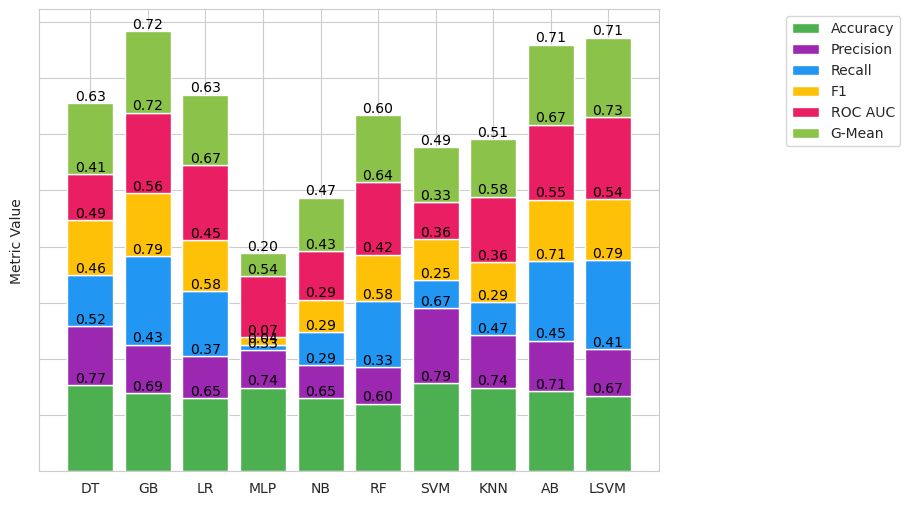

Gráfico salvo em: ../results/bar_plot_all_models.png


In [10]:
# Configure the seaborn style
sns.set_style("whitegrid")

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bars for each metric
bars = ax.bar(range(len(results_df)), results_df['Accuracy'], label='Accuracy', color='#4CAF50')  # Green
for i, (bar, value) in enumerate(zip(bars, results_df['Accuracy'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Precision'], bottom=results_df['Accuracy'], label='Precision', color='#9C27B0')  # Purple
for i, (bar, value) in enumerate(zip(bars, results_df['Precision'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + results_df['Accuracy'].iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Recall'], bottom=results_df['Accuracy'] + results_df['Precision'], label='Recall', color='#2196F3')  # Blue
for i, (bar, value) in enumerate(zip(bars, results_df['Recall'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['F1'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'], label='F1', color='#FFC107')  # Yellow
for i, (bar, value) in enumerate(zip(bars, results_df['F1'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['ROC AUC'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'], label='ROC AUC', color='#E91E63')  # Pink
for i, (bar, value) in enumerate(zip(bars, results_df['ROC AUC'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['G-Mean'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC'], label='G-Mean', color='#8BC34A')  # Light Green
for i, (bar, value) in enumerate(zip(bars, results_df['G-Mean'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

# Chart settings
ax.set_xticks(range(len(results_df)))
ax.set_yticklabels([])
ax.set_xticklabels(results_df['classifier'])
ax.set_ylabel('Metric Value')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# Display the graph
plt.show()

# Save the graphs
save_path = '../results/bar_plot_all_models.png'
fig.savefig(save_path, bbox_inches='tight')
print(f"Gráfico salvo em: {save_path}")


In [11]:
# Instantiating RandomUnderSampler
rus = RandomUnderSampler()

# Apply RandomUnderSampler to data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Creating a new DataFrame with the resampled data
df_ = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['PROVAVEL_HAM/TSP'])], axis=1)

y = df_['PROVAVEL_HAM/TSP']  # Target variable
X = df_.drop('PROVAVEL_HAM/TSP', axis=1)  # Predictor variables

(98, 9)


Learning Curves

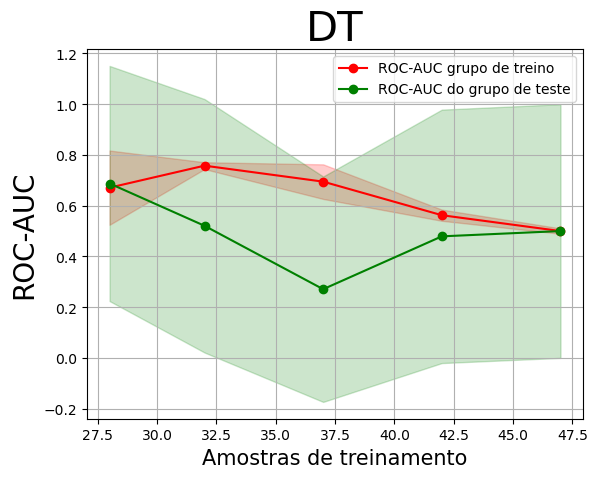

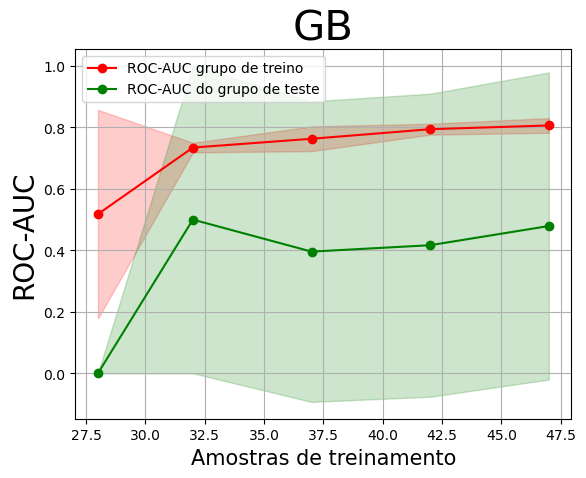

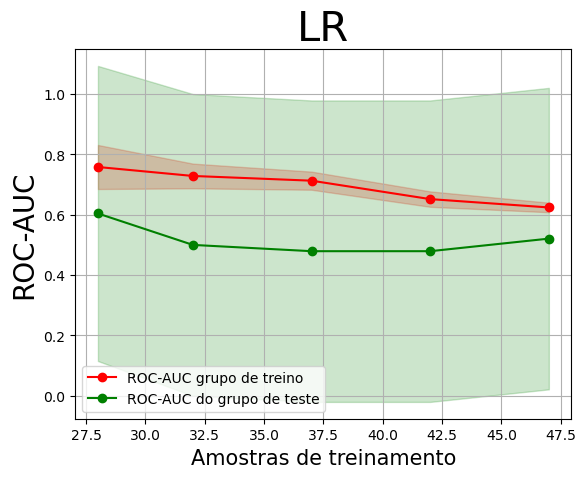

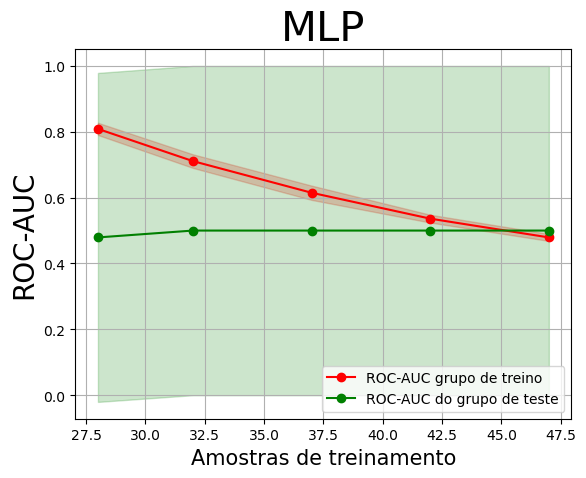

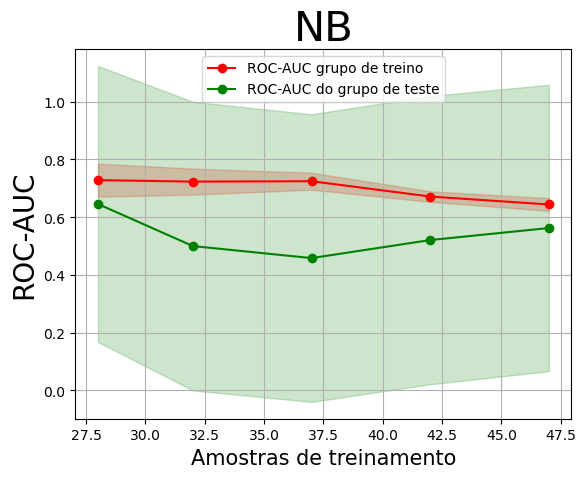

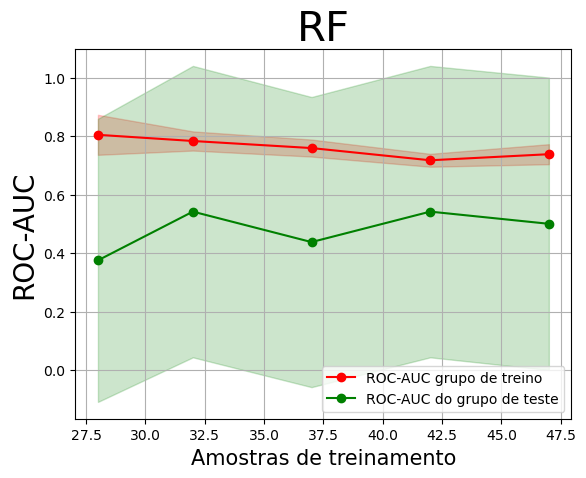

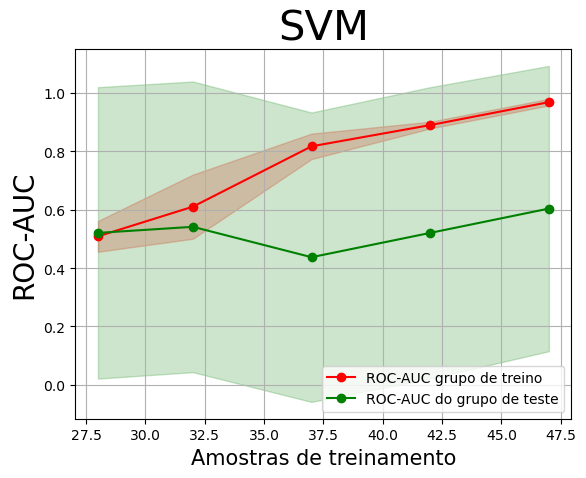

/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metri

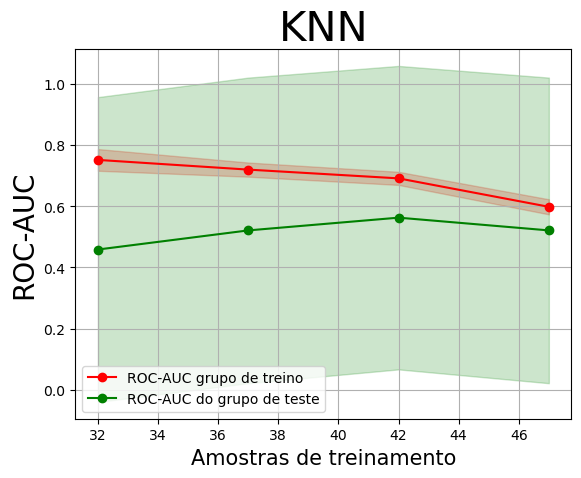

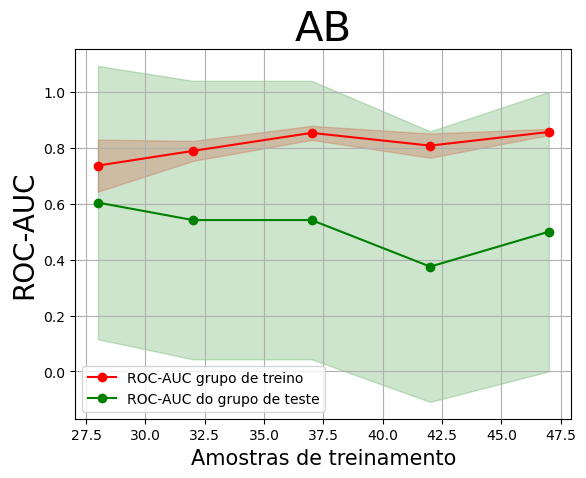

/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home

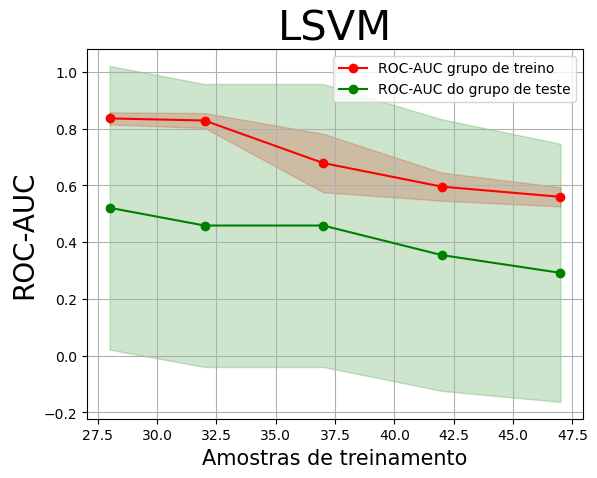

In [12]:
# Function to plot learning curves with shaded areas for standard deviation
def plot_learning_curve(X, y, classifiers, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '../results/'  # Adjust the directory path if needed
    for name, estimator in classifiers.items():
        # Get learning curve data
        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculate means and standard deviations
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curves
        plt.figure()
        plt.title(f'{name}', fontsize = 30)
        plt.xlabel("Amostras de treinamento", fontsize = 15)
        plt.ylabel("ROC-AUC", fontsize = 20)

        # Plot training data and fill between for standard deviation
        plt.plot(train_sizes_abs, train_scores_mean, 'o-', label="ROC-AUC grupo de treino", color="r")
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.2, color="r")  # Shadow for training

        # Plot test data and fill between for standard deviation
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', label="ROC-AUC do grupo de teste", color="g")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.2, color="g")  # Shadow for cross-validation

        # Show legend and grid
        plt.legend(loc="best")
        plt.grid(True)

        # Save the plot
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.show()

# Example usage: Call the plot_learning_curve function with your data
plot_learning_curve(X, y, classifiers)


Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AB carregado com sucesso.
Modelo LSVM carregado com sucesso.


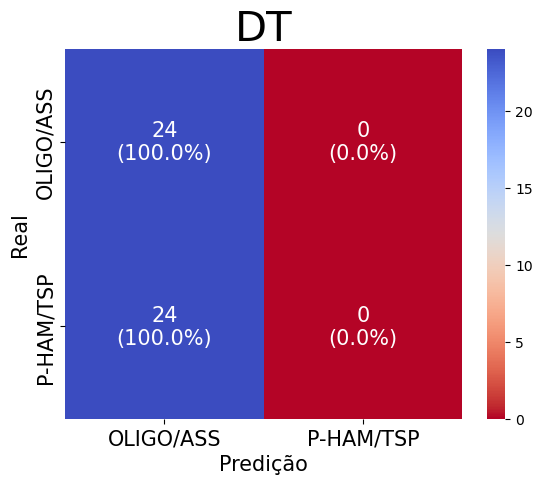

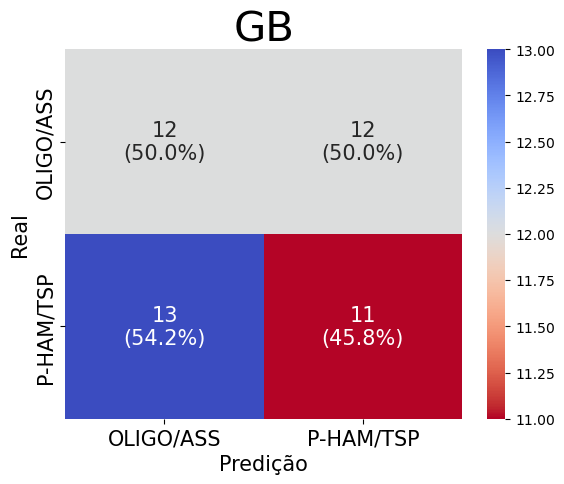

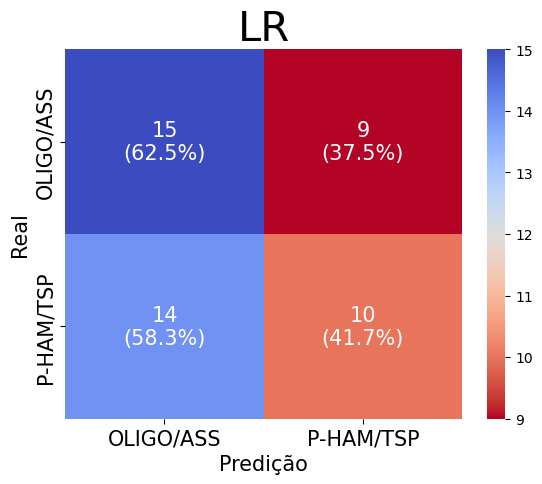

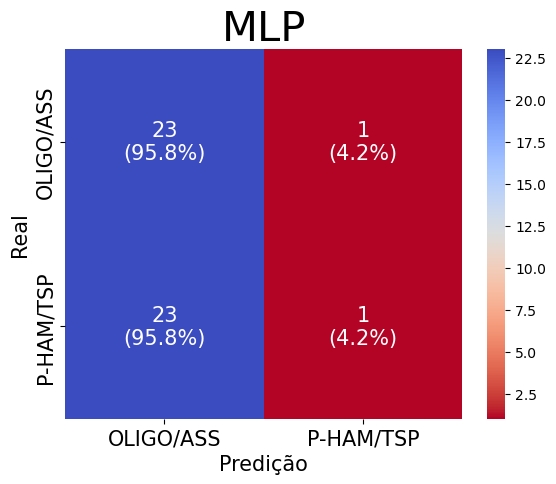

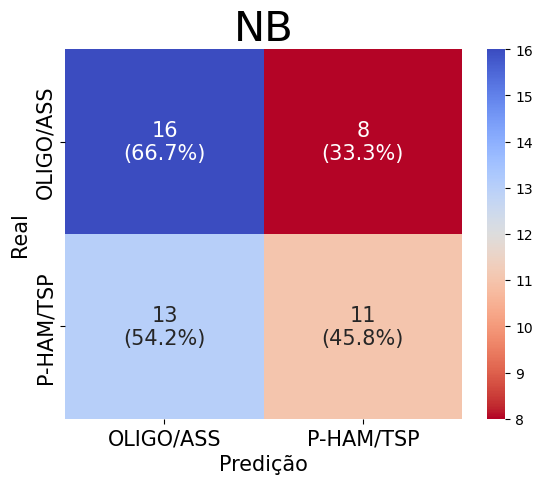

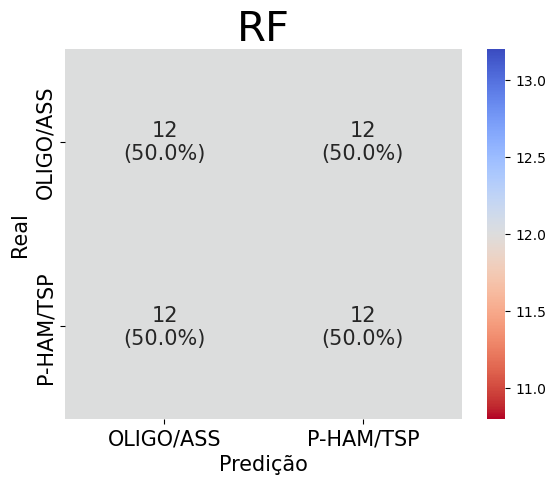

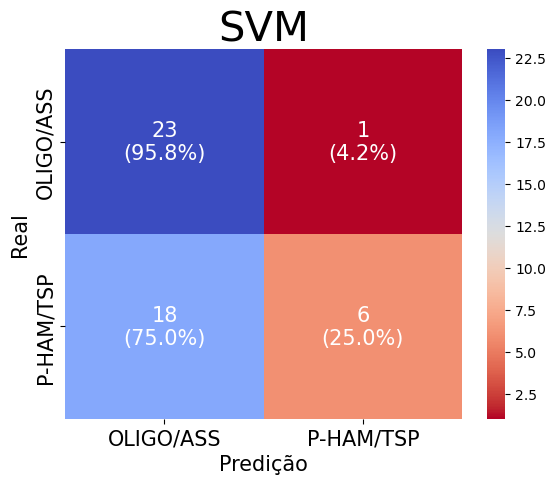

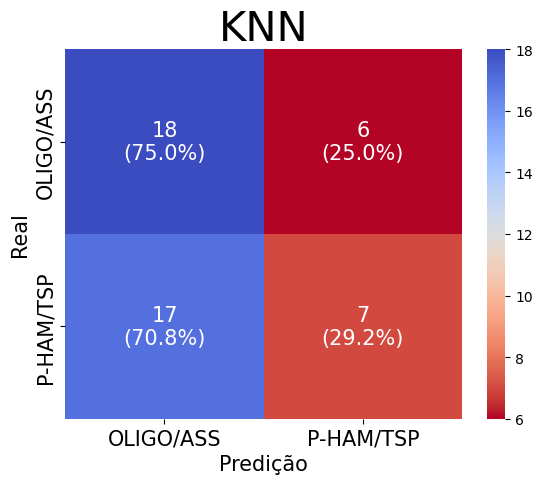

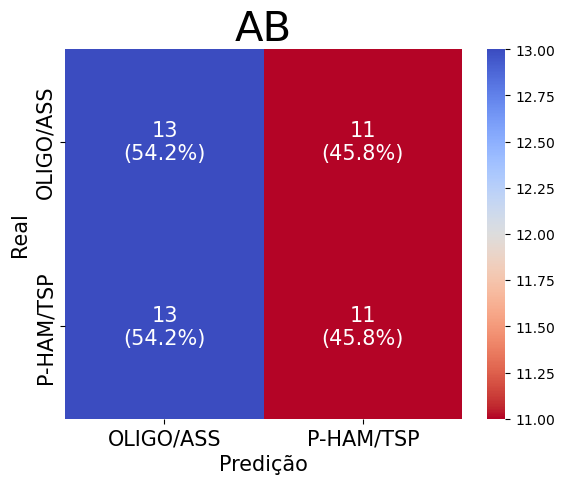

/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home

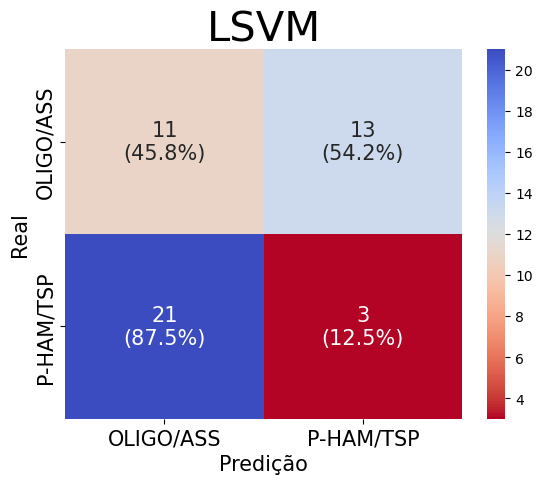

{'DT': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.08123959883573634,
                                        max_depth=4, min_samples_leaf=4,
                                        min_samples_split=8,
                                        random_state=42))]), 'GB': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.06610098295419149,
                                            max_depth=9, min_samples_leaf=7,
                                            min_samples_split=14,
                                            n_estimators=236, random_state=42,
                                            subsample=0.6376918441602301))]), 'LR': Pipeline(steps=[('normalization', Mi

In [13]:
# Function to plot confusion matrix with percentages per row
def plot_confusion_matrix(model_name, X, y, loo):
    model = classifiers[model_name]
    
    # Making predictions using cross_val_predict
    y_preds = cross_val_predict(model, X, y, cv=loo)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y, y_preds)
    
    # Convert confusion matrix to percentages per row
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent = np.nan_to_num(cm_percent)  # Handle divisions by zero
    
    # Define custom labels

    labels = ['OLIGO/ASS', 'P-HAM/TSP']

    # Create annotations combining absolute values and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    # Plot the heat map with larger annotation font size
    sns.heatmap(
        cm, 
        annot=annot, 
        fmt='', 
        cmap='coolwarm_r', 
        xticklabels=labels, 
        yticklabels=labels,
        annot_kws={"size": 15}  # Adjust the font size of the annotations here
    )
    
    # Adjust the label size for x and y ticks
    plt.xticks(fontsize=15)  # Size of x-axis labels (PVHTLV, HAM/TSP)
    plt.yticks(fontsize=15)  # Size of y-axis labels (PVHTLV, HAM/TSP)
    plt.xlabel('Predição', fontsize=15)
    plt.ylabel('Real', fontsize=15)
    plt.title(f'{model_name}', fontsize=30)
    
    # Save the picture
    plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

# Example: Assume X, y, and loo are already defined as your dataset and cross-validation strategy
# You can now plot the confusion matrix for each model
for model_name in model_names:
    if model_name in classifiers:  # Only plot if the model is loaded successfully
        plot_confusion_matrix(model_name, X, y, loo)

# Print the classifiers dictionary to verify if models were loaded successfully
print(classifiers)


In [14]:
def plot_learning_curve(X, y, classifiers, balancing_method, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '../results/'
    
    # Make sure the results directory exists
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    for name, clf in classifiers.items():
        # Defining the pipeline
        pipeline = Pipeline([
            ('balancing', balancing_method),  # Balanceamento usando método selecionado
            ('classifier', clf)  # Classificador
        ])
        
        # Calculating learning curves
        train_sizes_abs, train_scores, test_scores = learning_curve(
            pipeline, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculating the averages and standard deviations of training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plotting the learning curves
        plt.figure()
        plt.title(f'Curva de aprendizado - {name}')
        plt.xlabel("Amostras de treino")
        plt.ylabel("Acurácia")

        plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Amostras de treino")
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Amostras de tste")

        # Filling in error areas
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.1, color="r")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.1, color="g")

        plt.legend(loc="best")
        plt.grid(True)
        
        # Saving the plot
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.close()  

plot_learning_curve(X, y, classifiers, balancing_method)


/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bioinfo-icb/anaconda3/envs/ML_HTLV/lib/python3.11/site-packages/sklearn/metri